# **Federated VAE Comparison**

This notebook compares the performance of a Variational Autoencoder (VAE) on generating MNIST data. The VAE will be trained in two ways:

   * Standard - trained on a typical train split of the MNIST dataset.
   * Federated - trained in a federated manner split between diffrent clients.

Inspiration for diffirent parts of the code have come from the following resources:

   * [VAE model](https://towardsdatascience.com/building-a-convolutional-vae-in-pytorch-a0f54c947f71)
   * [Federated training](https://epione.gitlabpages.inria.fr/flhd/federated_learning/federated_mcvae.html)
   * [t-SNE implementation](https://danielmuellerkomorowska.com/2021/01/05/introduction-to-t-sne-in-python-with-scikit-learn/)


### **i. Imports and functions**

In [1]:
# Imports
import copy
import torch
import tqdm
import gc
import os
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from numba import cuda 
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from sklearn.manifold import TSNE

# Functions for analysis
def split_data_iid(dataset, n_centres):
    """ Split PyTorch dataset
        randomly into n_centres.
    """
    inputs_per_centre = [len(dataset) // n_centres for _ in range(n_centres)]
    return random_split(dataset, inputs_per_centre), inputs_per_centre

def federated_averaging(models, inputs_per_centre):
    """ Perform federated averaging
        of client models using FedAvg.
        """
    # Compute averaging proportions
    total_inputs = sum(inputs_per_centre)
    proportions = [client_inputs/total_inputs for client_inputs in inputs_per_centre]

    # Initiliase model paramater dictionary
    avg_params = models[0].state_dict()
    for key, val in avg_params.items():
        avg_params[key] = torch.zeros_like(val, dtype=torch.float32)

    # Compute average
    for model, proportion in zip(models, proportions):
        for key in avg_params:
            avg_params[key] += proportion * model.state_dict()[key]
            
    # Copy one of the models and load averaged parameters
    avg_model = copy.deepcopy(models[0])
    avg_model.load_state_dict(avg_params)

    return avg_model

def loss_plot(epochs, loss, axs=False):
    """ Plot loss curve."""
    if axs:
      axs.plot(epochs, loss)
    else:
      plt.plot(epochs, loss)

def show(img):
    """ Display MNIST image."""
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


### **ii. General setup**

In [2]:
# Training hyperparameters
N_ROUNDS = 15
N_CENTRES = 4
N_EPOCHS = 25
N_FEATURES = [28,28]
BATCH_SIZE = 128
LATENT_DIM = 200

# GPU settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    gc.collect()
    torch.cuda.empty_cache()
    device = cuda.get_current_device()
    device.reset()

# Load data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="~/torch_datasets", train=True,
                               transform=transform, download=True)
test_dataset = datasets.MNIST(root="~/torch_datasets", train=False,
                              transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

# Federate data
federated_dataset, inputs_per_centre = split_data_iid(train_dataset, n_centres=4)

# Put data into dataloader
for i, dataset in enumerate(federated_dataset):
    federated_dataset[i] = DataLoader(dataset, batch_size=BATCH_SIZE,
                                      shuffle=True, num_workers=2,
                                      pin_memory=True)
    
# Figure dir and params
figure_dir = os.path.join('./figures')
os.makedirs(figure_dir, exist_ok=True)
plt.rcParams["savefig.bbox"] = 'tight'

## **1. Define VAE model**

In [3]:
class VAE(nn.Module):
    """ Convulutional VAE model."""
    def __init__(self,
                 in_features=[28, 28],
                 in_channels=1,
                 latent_dim=200,
                 feature_dim=[32, 24, 24]):
        super(VAE, self).__init__()

        # Assign variables
        self.in_features = in_features
        self.in_channels = in_channels
        self.latent_dim = latent_dim
        self.feature_dim = feature_dim
        self.total_feature_dim = self.feature_dim[0]*self.feature_dim[1]*self.feature_dim[2]

        # Build Encoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Conv2d(self.in_channels, 16, kernel_size=3),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                nn.Conv2d(16, 32, kernel_size=3),
                nn.BatchNorm2d(32),
                nn.LeakyReLU()
                )
        )
        self.encoder = nn.Sequential(*modules)

        # Linear layers defining distribution parameters
        self.fc_mu = nn.Linear(self.total_feature_dim, self.latent_dim)
        self.fc_var = nn.Linear(self.total_feature_dim, self.latent_dim)

        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(self.latent_dim, self.total_feature_dim)
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(32, 16, kernel_size=3),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(16, self.in_channels, kernel_size=3),
                nn.BatchNorm2d(self.in_channels),
                nn.Sigmoid()
                )
        )
        self.decoder = nn.Sequential(*modules)
      
    def encode(self, x):
        """ Encode input to mean and logvar."""
        result = self.encoder(x)
        result = result.view(result.shape[0], self.total_feature_dim)
        mu = self.fc_mu(result)
        logvar = self.fc_var(result)

        return [mu, logvar]
    
    def reparameterise(self, mu, logvar):
        """ Reparameterise to sample."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        
        return eps * std + mu

    def decode(self, z):
        """ Decode latent sampling to output."""
        result = self.decoder_input(z)
        result = result.view(result.shape[0], self.feature_dim[0],
                             self.feature_dim[1], self.feature_dim[2])
        result = self.decoder(result)

        return result

    def forward(self, x):
        """ Forward pass of the network."""
        # Check input matches in_features
        if list(x.shape[-2:]) != self.in_features:
            raise Exception(f'Input features must be equal to {self.in_features}!')
        
        # Encode input to mean and logvar
        mu, logvar = self.encode(x)

        # Reparameterise
        z = self.reparameterise(mu, logvar)

        # Decode
        return [self.decode(z), mu, logvar]

# Loss function
class VAELoss(nn.Module):
    """ Loss function for VAE
        using BCE loss and KL 
        divergence.
    """
    def __init__(self):
        super(VAELoss, self).__init__()
        self.criterion = F.binary_cross_entropy

    def forward(self, outputs, inputs, mu, logvar, Beta=5):   
        recon_loss = self.criterion(outputs, inputs, reduction='sum')
        kl = 0.5 * torch.sum(-1 - logvar + mu.pow(2) + logvar.exp())

        return recon_loss, kl, recon_loss + kl

## **2. Train Standard VAE**

In [4]:
# Initiliase standard model
StandardVAE = VAE(in_features=N_FEATURES, in_channels=1, latent_dim=200).to(device)
params = sum(p.numel() for p in StandardVAE.parameters() if p.requires_grad)
print("Total number of parameters for the Standard VAE: {}\n".format(params))
print("Standard VAE architecture:")
print(StandardVAE)

# Optimiser and loss
optimizer = torch.optim.Adam(StandardVAE.parameters(), lr=1e-3)
criterion = VAELoss()

Total number of parameters for the Standard VAE: 11087731

Standard VAE architecture:
VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=18432, out_features=200, bias=True)
  (fc_var): Linear(in_features=18432, out_features=200, bias=True)
  (decoder_input): Linear(in_features=200, out_features=18432, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3):

In [5]:
# Initialise loss dictionary
losses = {'Reconstruction': [],
          'KL': [],
          'Training': []
          }

# Begin training
print('Beginning Standard VAE training...\n')
StandardVAE.train()

# Loop over epochs
for epoch in range(N_EPOCHS):
    # Running loss containers
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    running_train_loss = 0.0

    # Loop over batches
    with tqdm.tqdm(train_loader, unit="batch") as tepoch: 
        for batch_idx, (data, label) in enumerate(tepoch):
          # Batch tensor
          batch_tensor = data.to(device)

          # Compute reconstructions
          results, mu, logvar = StandardVAE(batch_tensor)

          # Loss
          recon_loss, kl_loss, train_loss = criterion(results, batch_tensor,
                                                      mu=mu, logvar=logvar)

          # Backpropagation based on the loss
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()

          # Update loss
          running_recon_loss += recon_loss.item()
          running_kl_loss += kl_loss.item()
          running_train_loss += train_loss.item()

          # Log
          if batch_idx % 20 == 0:
            tepoch.set_description(f"Epoch {epoch+1}")
            tepoch.set_postfix(loss=train_loss.item())

        # Average epoch loss
        losses['Reconstruction'].append(running_recon_loss/batch_idx+1)
        losses['KL'].append(running_kl_loss/batch_idx+1)
        losses['Training'].append(running_train_loss/batch_idx+1)

Beginning Standard VAE training...



Epoch 9:  70%|███████   | 329/469 [00:05<00:02, 65.25batch/s, loss=1.73e+4]


KeyboardInterrupt: 

## **3. Train Federated VAE**

In [ ]:
# Create federated model
FederatedVAE = VAE(in_features=N_FEATURES, in_channels=1, latent_dim=200).to(device)

# Optimiser and loss
FederatedVAE.optimizer = torch.optim.Adam(FederatedVAE.parameters(), lr=1e-3)
criterion = VAELoss()

# Copy models across centres
models = [copy.deepcopy(FederatedVAE) for _ in range(N_CENTRES)]

In [ ]:
# Loss dictionary
fed_losses = {'Reconstruction': [],
              'KL': [],
              'Training': []
             }

# Begin training
print('Beginning Federated VAE training...\n')
init_params = FederatedVAE.state_dict()

# Loop over training rounds and clients
for round_idx in range(N_ROUNDS):
    # Running loss containers
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    running_train_loss = 0.0
    for client_idx, (client_dataset,
                     client_model) in enumerate(zip(federated_dataset,
                                                    models)):
        # Load initial parameters
        client_model.load_state_dict(init_params)
        client_model.train()

        # Loop over epochs and batches
        for epoch in range(int(N_EPOCHS/N_CENTRES)):
            with tqdm.tqdm(client_dataset, unit="batch") as tepoch: 
                for batch_idx, (data, label) in enumerate(tepoch):  
                    # Batch tensor
                    batch_tensor = data.to(device)

                    # Compute reconstructions
                    results, mu, logvar = client_model(batch_tensor)

                    # Loss
                    recon_loss, kl_loss, train_loss = criterion(results, batch_tensor,
                                                                mu=mu, logvar=logvar)

                    # Backpropagation based on the loss
                    client_model.optimizer.zero_grad()
                    train_loss.backward()
                    client_model.optimizer.step()

                    # Update loss
                    running_recon_loss += recon_loss.item()
                    running_kl_loss += kl_loss.item()
                    running_train_loss += train_loss.item()

                    # Log
                    if batch_idx % 20 == 0:
                        tepoch.set_description(f"Round {round_idx+1}, Client {client_idx+1}, Epoch {epoch+1}")
                        tepoch.set_postfix(loss=train_loss.item())

    # Aggregate models and save parameters
    trained_model = federated_averaging(models, inputs_per_centre)
    init_params = trained_model.state_dict()

    # Average loss over round
    fed_losses['Reconstruction'].append(running_recon_loss/(batch_idx+1)*4)
    fed_losses['KL'].append(running_kl_loss/(batch_idx+1)*4)
    fed_losses['Training'].append(running_train_loss/(batch_idx+1)*4)

# Save final model
FederatedVAE = trained_model

Beginning Federated VAE training...



Round 15, Client 4, Epoch 6: 100%|██████████| 118/118 [00:01<00:00, 101.93batch/s, loss=1.34e+4]


## **4. Results**

### **4.1 Loss curves**

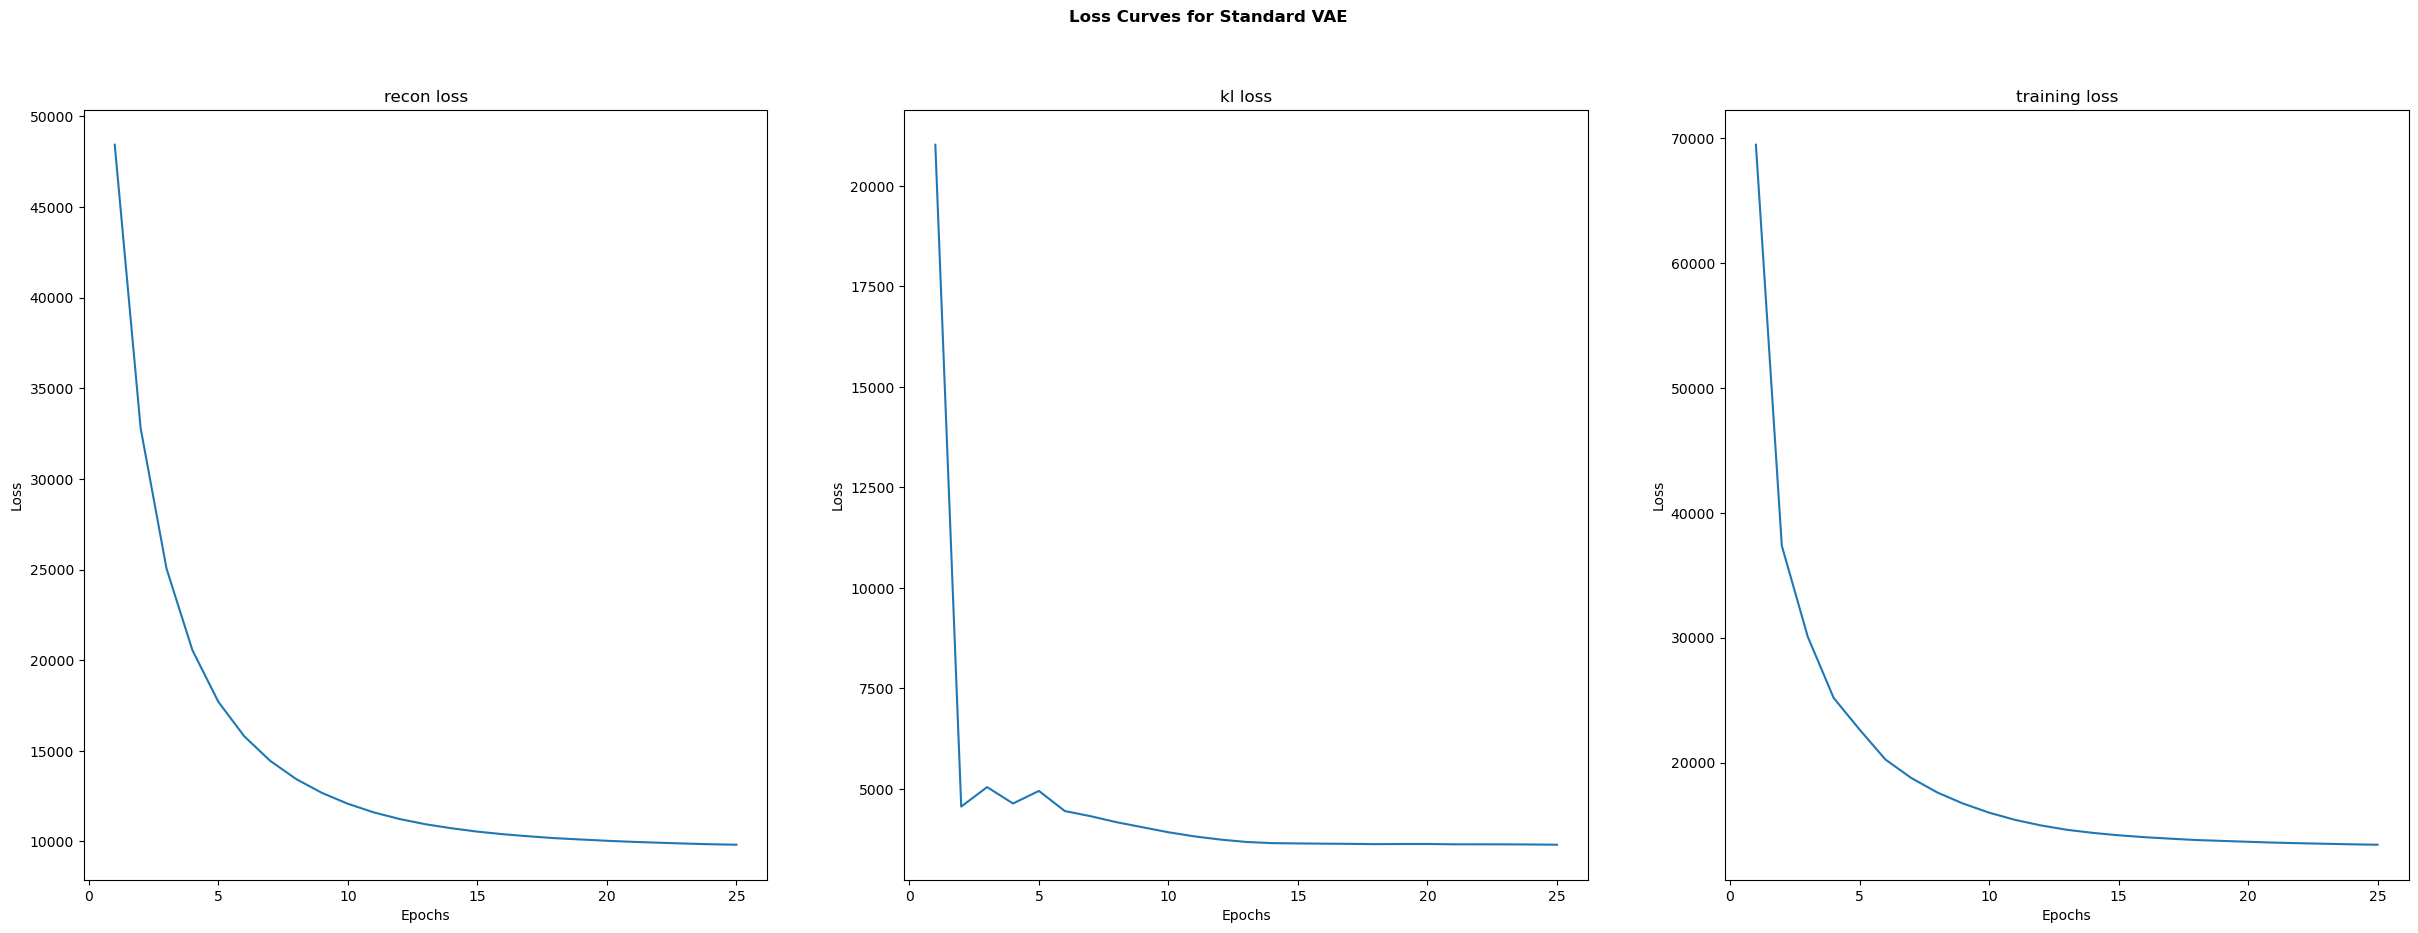

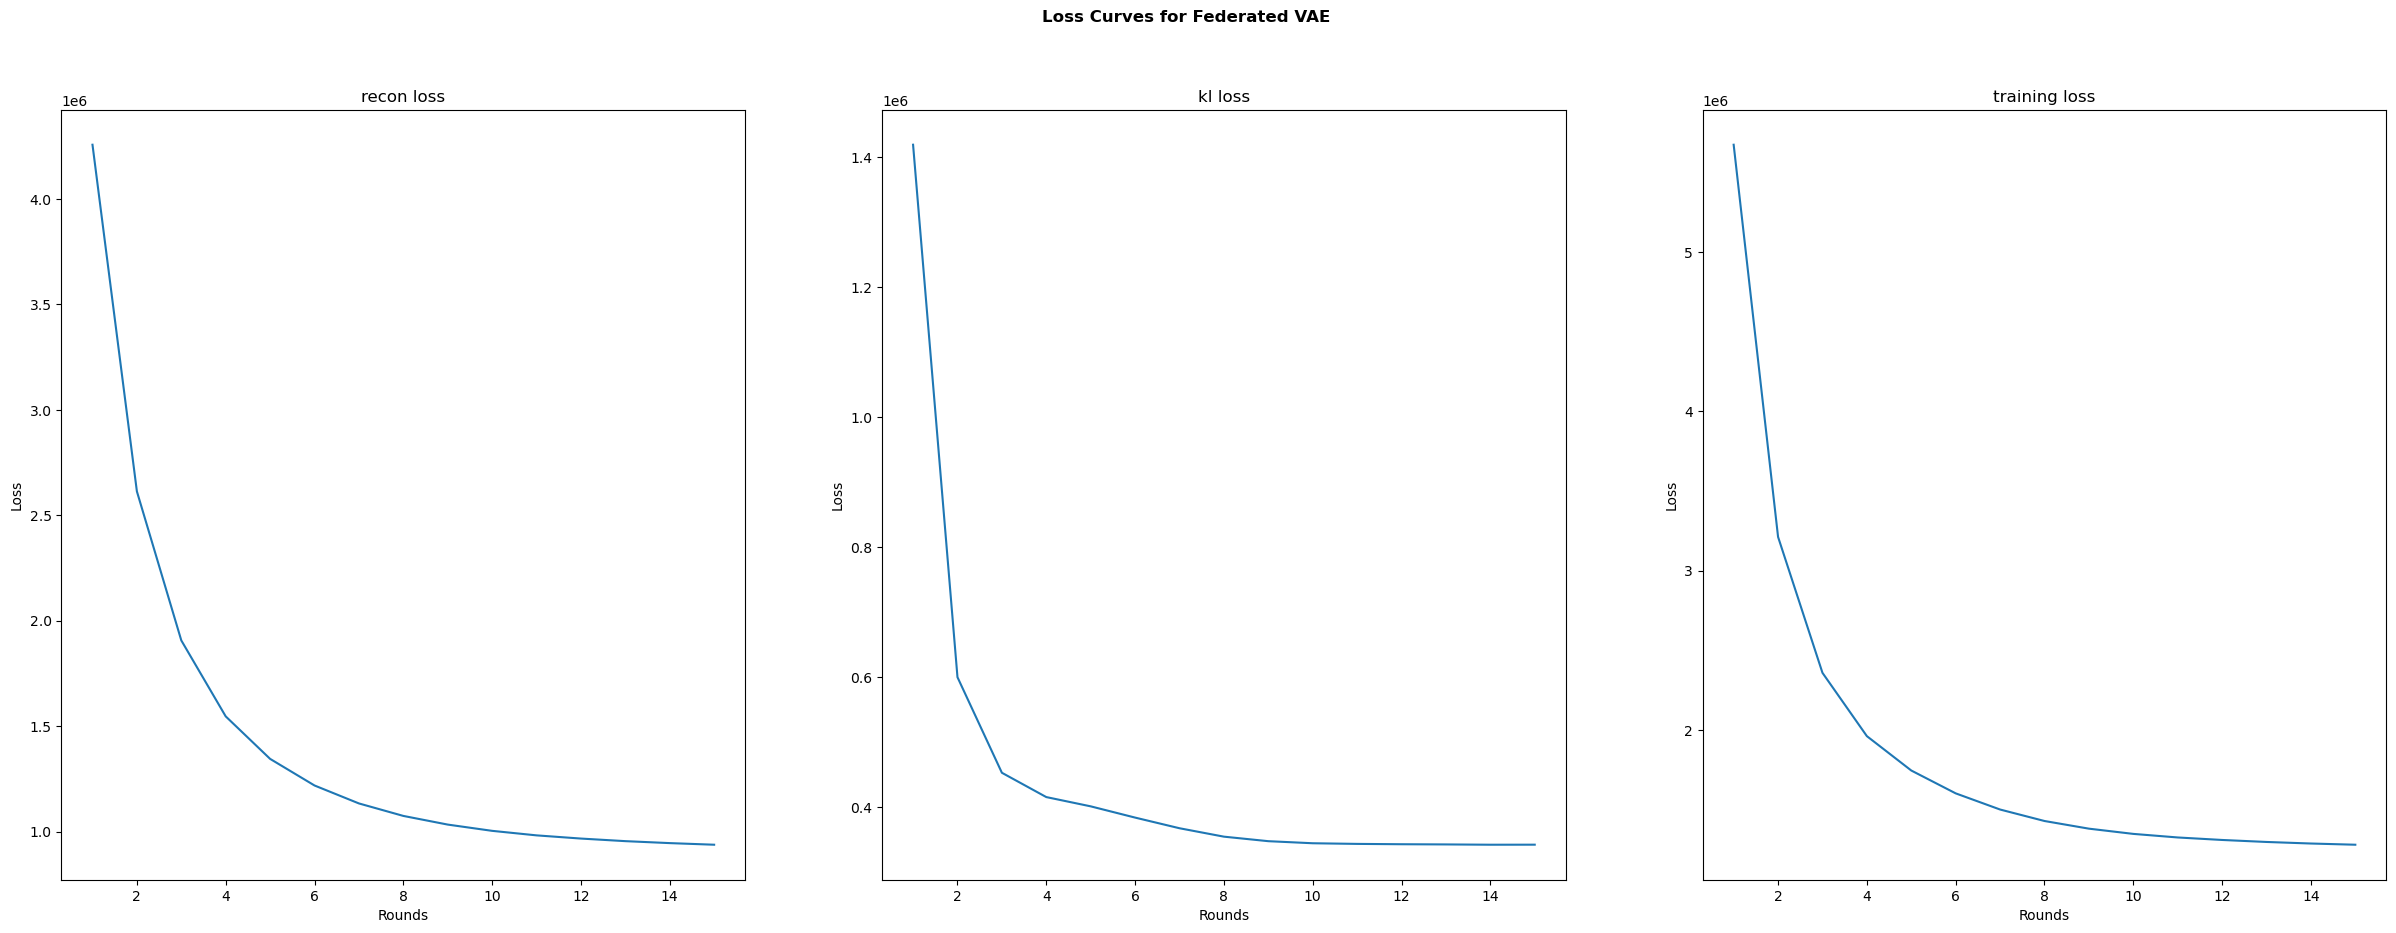

In [18]:
# Loss plots
fig, axs = plt.subplots(1,3, figsize=(30,10))
plt.suptitle("Loss Curves for Standard VAE", fontweight='bold')
for i, k in enumerate(losses):
  loss_plot(np.linspace(1, N_EPOCHS, N_EPOCHS).astype(int), losses[k], axs=axs[i])
  axs[i].set_title(f"{k} loss")
  axs[i].set_xlabel('Epochs')
  axs[i].set_ylabel('Loss')
plt.savefig(os.path.join(figure_dir, 'standard_loss_curve'), bbox_inches='tight')

# Loss plots
fig, axs = plt.subplots(1,3, figsize=(30,10))
plt.suptitle("Loss Curves for Federated VAE", fontweight='bold')
for i, k in enumerate(fed_losses):
  loss_plot(np.linspace(1, N_ROUNDS, N_ROUNDS).astype(int), fed_losses[k], axs=axs[i])
  axs[i].set_title(f"{k} loss")
  axs[i].set_xlabel('Rounds')
  axs[i].set_ylabel('Loss')
plt.savefig(os.path.join(figure_dir, 'federated_loss_curve'))

### **4.2 Images**

Input images
--------------------------------------------------


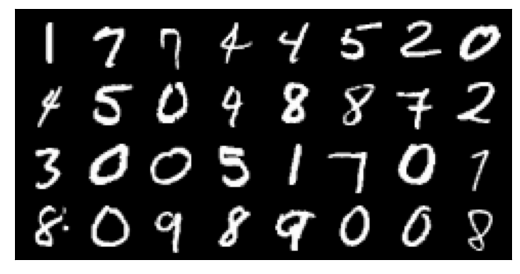

Standard Reconstructed images
--------------------------------------------------


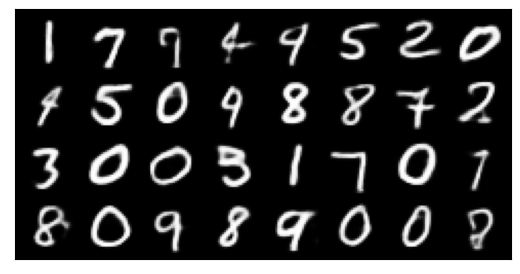

Federated Reconstructed images
--------------------------------------------------


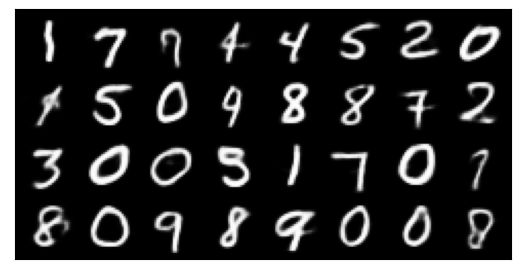

Standard Generated Images
--------------------------------------------------


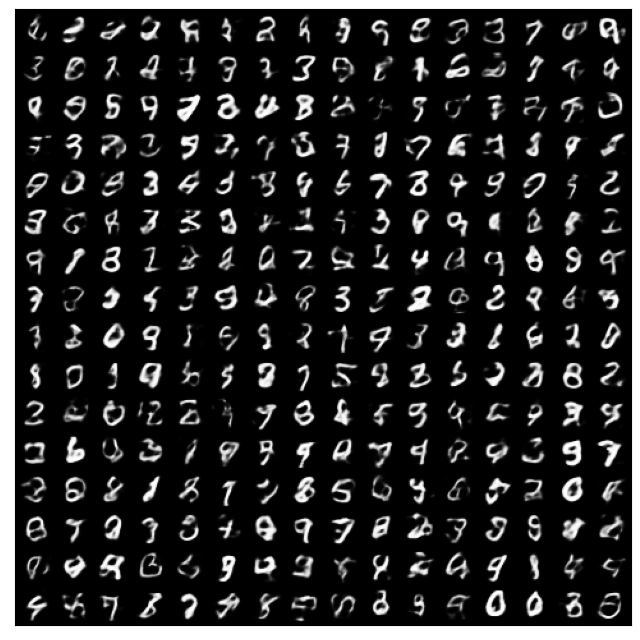

Federated Generated Images
--------------------------------------------------


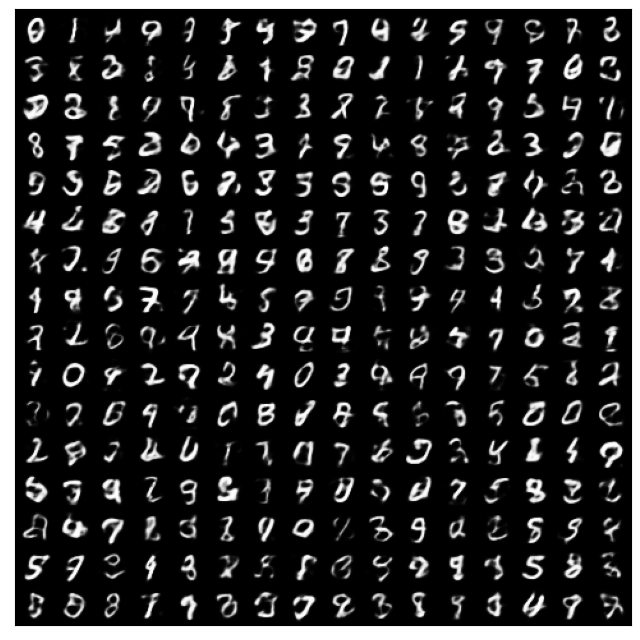

In [26]:
# Visualise original images
print('Input images')
print('-'*50)
sample_inputs, _ = next(iter(test_loader))
fixed_input = sample_inputs[0:32, :, :, :]
img = make_grid(fixed_input, nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
show(img)
plt.savefig(os.path.join(figure_dir, 'inputs'))
plt.show()


print('Standard Reconstructed images')
print('-'*50)
StandardVAE.eval()
with torch.no_grad():
    # Visualize the reconstructed images of the last batch of test set
    fixed_input = fixed_input.to(device)
    recon_batch = StandardVAE(fixed_input)
    recon_batch = recon_batch[0].cpu()
    recon_batch = recon_batch.view(recon_batch.shape[0], 1, 28, 28)
    recon_batch = make_grid(recon_batch, nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    show(recon_batch)
    plt.savefig(os.path.join(figure_dir, 'standard_reconstructions'))
    plt.show()

print('Federated Reconstructed images')
print('-'*50)
FederatedVAE.eval()
with torch.no_grad():
    # Visualize the reconstructed images of the last batch of test set
    fixed_input = fixed_input.to(device)
    recon_batch = FederatedVAE(fixed_input)
    recon_batch = recon_batch[0].cpu()
    recon_batch = recon_batch.view(recon_batch.shape[0], 1, 28, 28)
    recon_batch = make_grid(recon_batch, nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    show(recon_batch)
    plt.savefig(os.path.join(figure_dir, 'federated_reconstructions'))
    plt.show()

print('Standard Generated Images')  
print('-'*50)
StandardVAE.eval()
n_samples = 256
z = torch.randn(n_samples, LATENT_DIM).to(device)
with torch.no_grad():
    samples = StandardVAE.decode(z)
    samples = samples.view(n_samples, 1, 28, 28)
    samples = samples.cpu()
    samples = make_grid(samples, nrow=16, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    show(samples)
    plt.savefig(os.path.join(figure_dir, 'standard_generations'))
    plt.show()

print('Federated Generated Images')  
print('-'*50)
FederatedVAE.eval()
n_samples = 256
z = torch.randn(n_samples, LATENT_DIM).to(device)
with torch.no_grad():
    samples = FederatedVAE.decode(z)
    samples = samples.view(n_samples, 1, 28, 28)
    samples = samples.cpu()
    samples = make_grid(samples, nrow=16, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.savefig(os.path.join(figure_dir, 'federated_generations'))
    show(samples)
    plt.show()

### **4.3 t-SNE analysis**

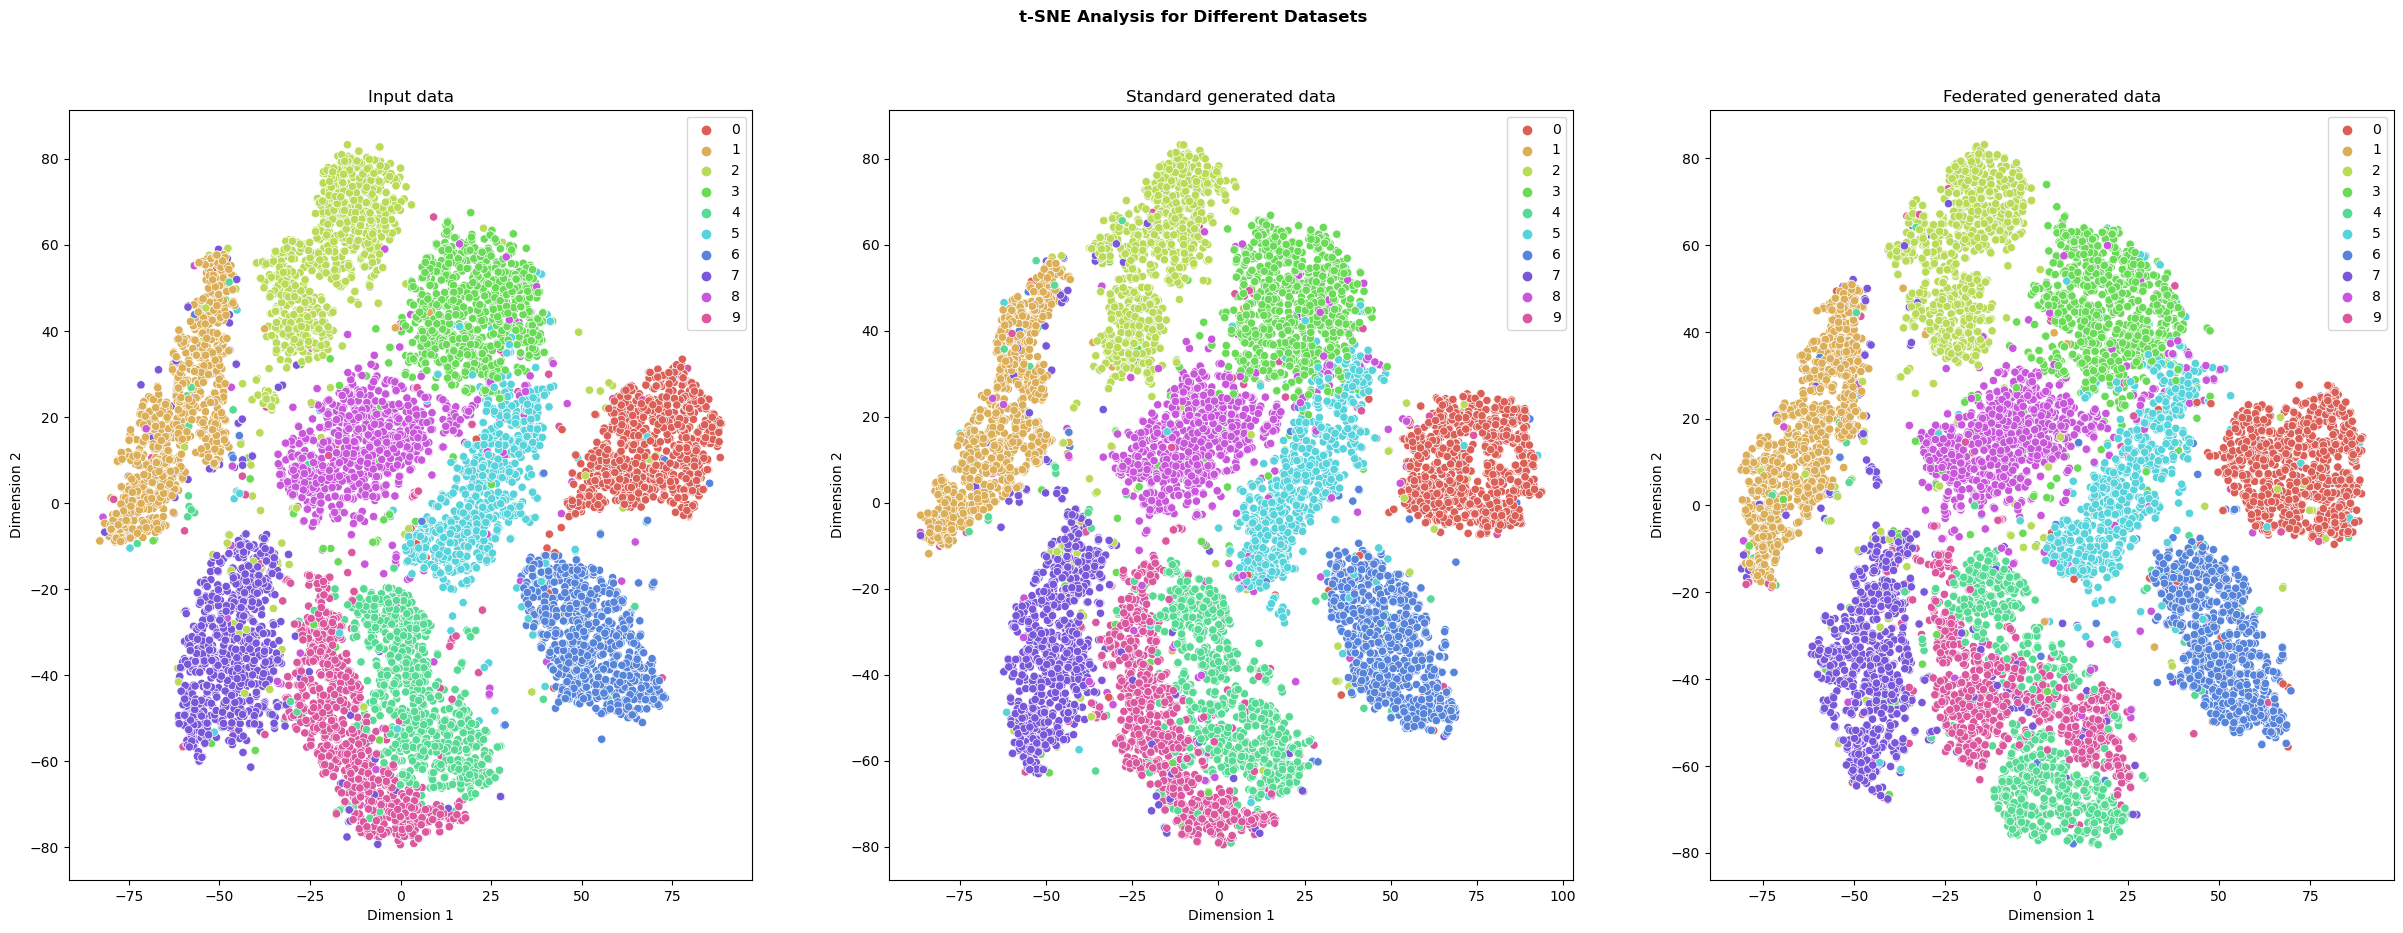

In [27]:
# Containers for test evaluation
feds = []
standards = []
data_list = []
labels = []

# Run test data through models
StandardVAE.eval()
FederatedVAE.eval()
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(test_loader):
        data = data.to(device)
        fed_recon = FederatedVAE(data)[0].cpu()
        standard_recon = StandardVAE(data)[0].cpu()
        data.cpu()

        # Append to lists
        feds.append(fed_recon)
        standards.append(standard_recon)
        labels.append(label)
        data_list.append(data)

# Concatenate tensors
feds = torch.cat(feds).cpu()
feds = feds.view(feds.shape[0], -1)
standards = torch.cat(standards).cpu()
standards = standards.view(standards.shape[0], -1)
data_list = torch.cat(data_list).cpu()
data_list = data_list.view(data_list.shape[0], -1)
labels = torch.cat(labels).cpu()

# Create TSNE object
tsne = TSNE(n_components=2, verbose=0, random_state=0)

# Plot TSNE
fig, axs = plt.subplots(1, 3, figsize=(30,10))
plt.suptitle('t-SNE Analysis for Different Datasets', fontweight='bold')
for i, (tag, data) in enumerate(zip(['Input data',
                                     'Standard generated data',
                                      'Federated generated data'],
                                    [data_list, standards, feds])):
    z = tsne.fit_transform(data)
    df = pd.DataFrame()
    df["y"] = labels
    df["Dimension 1"] = z[:,0]
    df["Dimension 2"] = z[:,1]
    sns.scatterplot(x="Dimension 1", y="Dimension 2", hue=df.y.tolist(),
                    ax=axs[i], palette=sns.color_palette("hls", 10),
                    data=df).set(title=tag)
plt.savefig(os.path.join(figure_dir, 't-SNE plots'))
